# Ideas

- investigate:
    - nbbo spread effect on customer size
    - nbbo spread effect on price
    - momentum
    - mean reversion
    - beta to esa, beta to other stocks
    - pairs trading

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Config

In [162]:
_symbols = ["AAPL"]

## time
_start_hour = 9.5
_end_hour = 16
_time_precision = 1000

## fair generation
_initial_fair = 100
_fair_stdev = 0.1

_mean_revert_beta = 0.5

## bbo generation
_size_mean = 1000
_size_stdev = 100

_size_tick = 10
_price_tick = 0.05

In [163]:
# create times
times = []
for ms_time in np.arange(_start_hour * 3600 * _time_precision, _end_hour * 3600 * _time_precision, _time_precision):
    times += [int(ms_time)]


In [176]:
symbol = _symbols[0]

# create time series data
np.random.seed(0)
fairs = []

fair_chgs = np.random.normal(loc=0, scale=_fair_stdev, size=len(times))
mean_rev_term = -1 * _mean_revert_beta * pd.Series(fair_chgs).shift().fillna(0)
mean_rev_term = mean_rev_term.cumsum()

# give it a mean-reverting term
fairs = _initial_fair + np.cumsum(fair_chgs) + mean_rev_term




# create dataframe
df_bbo = pd.DataFrame({"ms_time": times, "fair": fairs})

sizes = np.random.normal(loc=_size_mean, scale=_size_stdev, size=len(times))

# create bbo data, size weighted
df_bbo["symbol"] = symbol

df_bbo["bid"] = df_bbo["fair"] // _price_tick * _price_tick
df_bbo["ask"] = df_bbo["bid"] + _price_tick

df_bbo["bidsz"] = sizes * (df_bbo["fair"] - df_bbo["bid"]) / _price_tick
df_bbo["asksz"] = sizes - df_bbo["bidsz"]

clean_fn = lambda x : np.maximum(_size_tick, x // _size_tick * _size_tick).astype(int)
df_bbo["bidsz"] = clean_fn(df_bbo["bidsz"])
df_bbo["asksz"] = clean_fn(df_bbo["asksz"])



In [181]:
# mid calculations
df_bbo["mid"] = df_bbo.eval("(bid + ask) / 2")
df_bbo["smid"] = df_bbo.eval("(bid * asksz + ask * bidsz) / (bidsz + asksz)")


In [186]:
## check against mark times
df_mark = df_bbo.copy()

In [187]:
mark_times = [0, 1, 2, 3, 5, 10, 30, 60, 120, 300, 600]
for mark_time in mark_times:
    for shift_col in ["mid", "smid"]:
        df_mark[f"{shift_col}_{mark_time}s"] = df_mark[shift_col].shift(-1 * mark_time)


In [188]:
df_mark = df_mark.dropna()

In [290]:
all_data = []

df_test = df_mark[["ms_time", "symbol", "smid"]].rename(columns={"smid": "trade_price"}).copy()
df_test["my_fair"] = df_mark["fair"].shift(1).fillna(100)
df_test["trade_dir"] = np.sign(df_test["my_fair"] - df_test["trade_price"])
df_test["trade_size"] = 1

## params
def backtest_trades(
    df_trade, 
    df_mark, 
    mark_times, 
    trade_at_mid=False,
    use_smid=True,
    ):
    
    """
    backtest_trades 
    - Takes DF of trades and DF of marks
    - Returns new copy of trade DF, containing `pnl_{mark_time}s` columns
    - Can set `trade_at_mid=True` to test generalized events at mark prices
    
    Params:
    df_trade - Dataframe with following columns:
        - symbol - str
        - ms_time - int
        - trade_dir - int (1 = Buy, -1 = Sell, 0 = No action)
        - trade_size - int
        - trade_price - float
    df_mark - DataFrame with following columns:
        - symbol - str
        - ms_time - int
        - smid_{mark_time}s - float
        - mid_{mark_time}s - float
    mark_times - List of mark times to test (in seconds)
    trade_at_mid - bool (default: False) - set True to use mid/smid price as trade price instead of df_trade["trade_price"]
    use_smid - bool (default: True) - set True to use smid instead of mid
    """
    
    df_trade = df_trade.copy()
    
    if use_smid:
        mark_cols = [f"smid_{mark_time}s" for mark_time in mark_times]
    else:
        mark_cols = [f"mid_{mark_time}s" for mark_time in mark_times]
    
    mark_cols = list(set(mark_cols + ["mid_0s"]))
        
    # merge marks into dataframe
    df_mark = df_trade[["ms_time", "symbol"]].merge(
        df_mark[["ms_time", "symbol", *mark_cols]], 
        on=["ms_time", "symbol"],
        how="left",
    )
    
    
    # mark to smid
    for mark_time, mark_col in zip(mark_times, mark_cols):
        trade_price = df_trade["trade_price"] if trade_at_mid else df_mark["mid_0s"]
            
        df_trade[f"pnl_{mark_time}s"] = (df_mark[mark_col] - df_trade["trade_price"]) * df_trade["trade_size"] * df_trade["trade_dir"]


    
    return df_trade


In [305]:
df_res1 = backtest_trades(
    df_test, 
    df_mark, 
    mark_times=mark_times,
    trade_at_mid=True,
    use_smid=True,
)



In [306]:
df_res2 = backtest_trades(
    df_test, 
    df_mark, 
    mark_times=mark_times,
    trade_at_mid=False,
    use_smid=True,
)



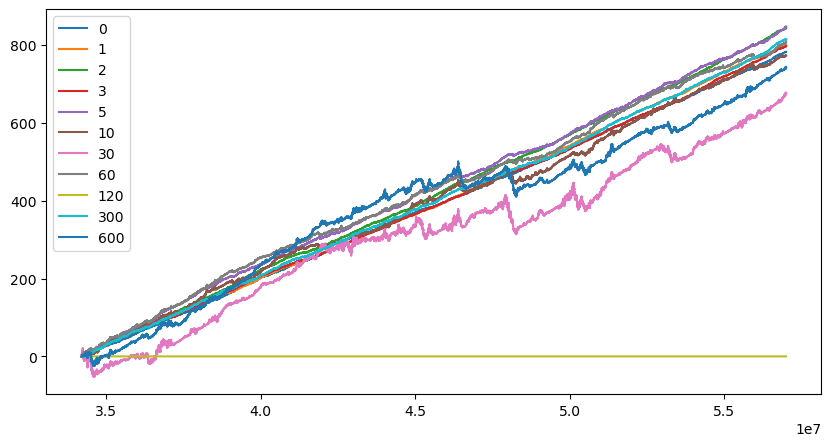

In [308]:
plt.figure(figsize=(10, 5))
# for mark_time in mark_times:
for mark_time in mark_times:
    plt.plot(df_res1["ms_time"], df_res1[f"pnl_{mark_time}s"].cumsum(), label=str(mark_time))

plt.legend()

In [ ]:
# create a way to test a strategy